# **CS224W - Colab 1**

本次实验中，我们会完整的写一遍学习结点嵌入的流水线，共经历如下三步：

首先，加载一个经典的图——[Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)。我们将看看这个图的多项统计数据。

然后，我们一起将图结构转换成PyTorch张量，以便进行图学习。

最终，我们会完成第一个图学习算法：结点嵌入模型。简单起见，我们的模型会比 Lecture 中讲的 DeepWalk 和 Node2Vec 算法简单，但仍然充满挑战并值得学习，因为我们要用 PyTorch 从零开始实现。

废话少说，现在开始！

**注意**：确保顺序执行所有代码单元，否则变量或库无法在之后的单元中使用。

## 1 图基础

首先，我们加载经典的图——[Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)。然后探索这个图的多项统计数据。

### 配置

本次实验将会重度依赖`NetworkX`库。

In [1]:
import networkx as nx

### Zachary's karate club网络

[Karate Club 网络](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) 是一个社交网络，描述了空手道俱乐部中的34位成员并记录了他们在俱乐部之外的互动关系。

In [2]:
G = nx.karate_club_graph()

# G is an undirected graph
print(type(G))

<class 'networkx.classes.graph.Graph'>


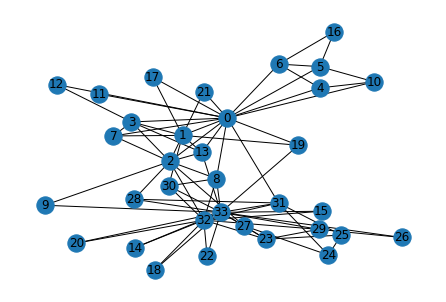

In [3]:
# Visualize the graph
nx.draw(G, with_labels = True)

### 问题1：在 Karate Club 网络中，平均结点的度是多少？

In [4]:
def average_degree(num_edges, num_nodes):
  # TODO: Implement this function that takes number of edges
  # and number of nodes, and returns the average node degree of 
  # the graph. Round the result to nearest integer (for example 
  # 3.3 will be rounded to 3 and 3.7 will be rounded to 4)

  avg_degree = num_edges * 2 / num_nodes

  return round(avg_degree)

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print(f"Average degree of karate club network is {avg_degree}")

Average degree of karate club network is 5


### 问题2：在 Karate Club 网络中，平均聚合系数是多少？

In [5]:
def average_clustering_coefficient(G):
  # TODO: Implement this function that takes a nx.Graph
  # and returns the average clustering coefficient. Round 
  # the result to 2 decimal places (for example 3.333 will
  # be rounded to 3.33 and 3.7571 will be rounded to 3.76)

  avg_cluster_coef = nx.average_clustering(G)

  return round(avg_cluster_coef, 2)

avg_cluster_coef = average_clustering_coefficient(G)
print(f"Average clustering coefficient of karate club network is {avg_cluster_coef}")

Average clustering coefficient of karate club network is 0.57


### 问题3：第一次迭代后，0号结点的 PageRank 值是多少？

PageRank 等式：$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$.

In [6]:
def one_iter_pagerank(G, beta, r0, node_id):
  # TODO: Implement this function that takes a nx.Graph, beta, r0 and node id.
  # The return value r1 is one interation PageRank value for the input node.
  # Please round r1 to 2 decimal places.

  r1 = 0

  ############# Your code here ############
  ## Note: 
  ## 1: You should not use nx.pagerank
  for node in G.neighbors(node_id):
    r1 += beta * (r0 / G.degree(node))
  r1 += (1 - beta) / G.number_of_nodes()
  #########################################

  return round(r1, 2)

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print(f"The PageRank value for node 0 after one iteration is {r1}")

The PageRank value for node 0 after one iteration is 0.13


### 问题4：在 Karate Club 网络中，5号结点的（原始）邻近中心性是多少？

邻近中心性等式：$c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$.

In [7]:
def closeness_centrality(G, node=5):
  # TODO: Implement the function that calculates closeness centrality 
  # for a node in karate club network. G is the input karate club 
  # network and node is the node id in the graph. Please round the 
  # closeness centrality result to 2 decimal places.

  closeness = nx.closeness_centrality(G, node) / (G.number_of_nodes() - 1)
  return round(closeness, 2)

node = 5
closeness = closeness_centrality(G, node=node)
print(f"The karate club network has closeness centrality {closeness}")

The karate club network has closeness centrality 0.01


## 2 将图转换为张量

我们接下来会一起将图 $G$ 转换为 PyTorch 张量，以便进行图机器学习。

### 配置

检查 PyTorch 是否正确安装。

In [8]:
import torch
print(torch.__version__)

1.11.0


### PyToch 张量基础

我们可以生成全是0的张量。同样地，全是1或随机值也行。

In [9]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.9181, 0.6768, 0.8109, 0.4612],
        [0.2245, 0.6754, 0.3801, 0.4729],
        [0.0166, 0.6582, 0.5284, 0.5120]])
torch.Size([3, 4])


一个 PyTorch 张量只能有一种数据类型，即 `dtype` 。

In [10]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


### 问题5：获取 Karate Club 网络的边集并将它转换为 `torch.LongTensor`。`pos_edge_index` 张量的 `torch.sum` 值是多少？

In [11]:
def graph_to_edge_list(G):
  # TODO: Implement the function that returns the edge list of
  # an nx.Graph. The returned edge_list should be a list of tuples
  # where each tuple is a tuple representing an edge connected 
  # by two nodes.

  edge_list = list(G.edges())
  return edge_list

def edge_list_to_tensor(edge_list):
  # TODO: Implement the function that transforms the edge_list to
  # tensor. The input edge_list is a list of tuples and the resulting
  # tensor should have the shape [2 x len(edge_list)].

  edge_index = torch.tensor(edge_list).T
  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print(f"The pos_edge_index tensor has shape {pos_edge_index.shape}")
print(f"The pos_edge_index tensor has sum value {torch.sum(pos_edge_index)}")

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


### 问题6：请实现下列负边采样的函数。然后回答 `edge_1` 到 `edge_5` 中哪些边可以是负边？

In [12]:
import random

def sample_negative_edges(G, num_neg_samples):
  # TODO: Implement the function that returns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples. You do not
  # need to consider the corner case when the number of possible negative edges
  # is less than num_neg_samples. It should be ok as long as your implementation 
  # works on the karate club network. In this implementation, self loop should 
  # not be considered as either a positive or negative edge. Also, notice that 
  # the karate club network is an undirected graph, if (0, 1) is a positive 
  # edge, do you think (1, 0) can be a negative one?

  neg_edge_list = []
  num_nodes = G.number_of_nodes()
  while num_neg_samples > 0:
    u, v = random.randrange(num_nodes), random.randrange(num_nodes)
    if (u, v) not in neg_edge_list and (u, v) not in G.edges():
      neg_edge_list.append((u, v))
      num_neg_samples -= 1
  return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print(f"The neg_edge_index tensor has shape {neg_edge_index.shape}")

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
## Note:
## 1: For each of the 5 edges, print whether it can be negative edge
print(f"Is edge ({edge_1[0]:2d}, {edge_1[1]:2d}) a negative edge?\t{edge_1 not in G.edges()}")
print(f"Is edge ({edge_2[0]:2d}, {edge_2[1]:2d}) a negative edge?\t{edge_2 not in G.edges()}")
print(f"Is edge ({edge_3[0]:2d}, {edge_3[1]:2d}) a negative edge?\t{edge_3 not in G.edges()}")
print(f"Is edge ({edge_4[0]:2d}, {edge_4[1]:2d}) a negative edge?\t{edge_4 not in G.edges()}")
print(f"Is edge ({edge_5[0]:2d}, {edge_5[1]:2d}) a negative edge?\t{edge_5 not in G.edges()}")
#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])
Is edge ( 7,  1) a negative edge?	False
Is edge ( 1, 33) a negative edge?	True
Is edge (33, 22) a negative edge?	False
Is edge ( 0,  4) a negative edge?	False
Is edge ( 4,  2) a negative edge?	True


## 3 结点嵌入学习

最终，我们要实现第一个图学习算法：结点嵌入模型。

### 配置

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.11.0


为了写我们的结点嵌入模型，我们将重度依赖于 PyTorch 中 [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) 模块。我们现在先看看 `nn.Embedding` 如何使用：

In [14]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print(f"Sample embedding layer: {emb_sample}")

Sample embedding layer: Embedding(4, 8)


我们可以用张量索引从嵌入矩阵中选择结点的嵌入。

In [15]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[-1.5022,  0.2120,  1.7411,  0.3456,  0.4293,  1.2061,  0.4835,  0.5087]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-1.5022,  0.2120,  1.7411,  0.3456,  0.4293,  1.2061,  0.4835,  0.5087],
        [ 0.5387,  1.3462, -0.9335, -0.6344, -0.9084, -0.6412,  0.2392,  0.7397]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


现在，轮到你来给我们的图创建一个结点嵌入矩阵了。

- Karate Club 网络中每个结点需要**16 维**向量。
- 嵌入矩阵初始值服从均匀分布，范围为 $[0,1)$ 。建议使用 [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html) 函数。

In [16]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # TODO: Implement this function that will create the node embedding matrix.
  # A torch.nn.Embedding layer will be returned. You do not need to change 
  # the values of num_node and embedding_dim. The weight matrix of returned 
  # layer should be initialized under uniform distribution. 

  emb = nn.Embedding(num_node, embedding_dim)
  emb.weight.data = torch.rand(num_node, embedding_dim)
  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print(f"Embedding: {emb}")

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


### 初始结点嵌入可视化

一种理解嵌入矩阵的方式就是在2D空间可视化。
此处我们已经替你实现了嵌入可视化函数。
我们首先用PCA来降低维度到2D空间。
然后可视化各点，并用涂色区分不同团体。

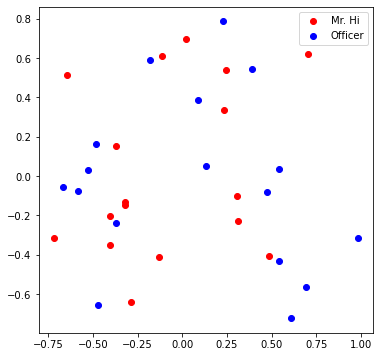

In [17]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node, club in G.nodes(data="club"):
    if club == "Mr. Hi":
      club1_x.append(components[node][0])
      club1_y.append(components[node][1])
    else:
      club2_x.append(components[node][0])
      club2_y.append(components[node][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

### 问题7：训练嵌入！你能获得的最好表现有多好？

In [18]:
from torch.optim import SGD

def accuracy(pred: torch.Tensor, label: torch.Tensor):
  # TODO: Implement the accuracy function. This function takes the 
  # pred tensor (the resulting tensor after sigmoid) and the label 
  # tensor (torch.LongTensor). Predicted value greater than 0.5 will 
  # be classified as label 1. Else it will be classified as label 0.
  # The returned accuracy should be rounded to 4 decimal places. 
  # For example, accuracy 0.82956 will be rounded to 0.8296.

  pred = (pred > 0.5).type(torch.int64)
  accu = (pred == label).count_nonzero()
  accu = accu.item() / pred.shape[0]

  return round(accu, 4)

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # TODO: Train the embedding layer here. You can also change epochs and 
  # learning rate. In general, you need to implement: 
  # (1) Get the embeddings of the nodes in train_edge
  # (2) Dot product the embeddings between each node pair
  # (3) Feed the dot product result into sigmoid
  # (4) Feed the sigmoid output into the loss_fn
  # (5) Print both loss and accuracy of each epoch 
  # (as a sanity check, the loss should decrease during training)

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    optimizer.zero_grad()
    u, v = emb(train_edge[0]), emb(train_edge[1])
    dot_product = torch.sum(u * v, dim=-1)
    pred = sigmoid(dot_product)
    loss = loss_fn(pred, train_label)
    print(f"[Epoch {i+1:3d}]: loss={round(loss.item(), 4)}, accuracy={accuracy(pred, train_label)}")
    loss.backward()
    optimizer.step()

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

[Epoch   1]: loss=2.0423, accuracy=0.5
[Epoch   2]: loss=2.029, accuracy=0.5
[Epoch   3]: loss=2.004, accuracy=0.5
[Epoch   4]: loss=1.9687, accuracy=0.5
[Epoch   5]: loss=1.9248, accuracy=0.5
[Epoch   6]: loss=1.8736, accuracy=0.5
[Epoch   7]: loss=1.8166, accuracy=0.5
[Epoch   8]: loss=1.7551, accuracy=0.5
[Epoch   9]: loss=1.6903, accuracy=0.5
[Epoch  10]: loss=1.6235, accuracy=0.5
[Epoch  11]: loss=1.5556, accuracy=0.5
[Epoch  12]: loss=1.4876, accuracy=0.5
[Epoch  13]: loss=1.4203, accuracy=0.5
[Epoch  14]: loss=1.3544, accuracy=0.5
[Epoch  15]: loss=1.2905, accuracy=0.5
[Epoch  16]: loss=1.2292, accuracy=0.5
[Epoch  17]: loss=1.1707, accuracy=0.5
[Epoch  18]: loss=1.1154, accuracy=0.5
[Epoch  19]: loss=1.0635, accuracy=0.5
[Epoch  20]: loss=1.015, accuracy=0.5
[Epoch  21]: loss=0.97, accuracy=0.5
[Epoch  22]: loss=0.9284, accuracy=0.5
[Epoch  23]: loss=0.8901, accuracy=0.5
[Epoch  24]: loss=0.855, accuracy=0.5128
[Epoch  25]: loss=0.8229, accuracy=0.5128
[Epoch  26]: loss=0.7936,

### 可视化最终的结点嵌入

让我们看看现在的嵌入和之前的结果有什么区别。训练之后，你应该能观察到不同类之间会更明显地区分开。这也可以检验你的实现是否合理。

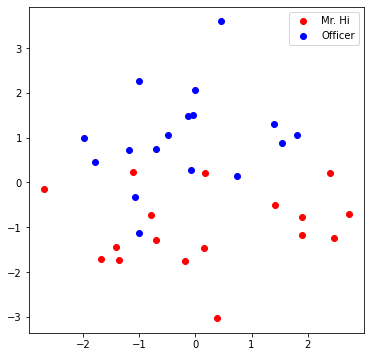

In [19]:
# Visualize the final learned embedding
visualize_emb(emb)